Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [33]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Rescaling, InputLayer

In [2]:
#ONS OCVN OV OM
print("ONS OCVN OV OM")

ONS OCVN OV OM


In [3]:
# Check version of tensorflow and keras
print("tensorflow ver: "+ tf.__version__)
print("keras ver: "+ keras.__version__)

tensorflow ver: 2.8.0
keras ver: 2.8.0


In [4]:
# Change directory to the base dir of sample imagesm so thqt it is e
#C:\Users\dpdha\Downloads\CNN_assignment
os.chdir("C:/Users/dpdha/Downloads/CNN_assignment/")
print(os.getcwd())
pd=pathlib.Path(os.getcwd())

C:\Users\dpdha\Downloads\CNN_assignment


In [5]:
# Check total number of images
print(len(list(pd.glob('*/*/*/*.jpg'))))

2357


In [6]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Images for training :", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Images for testing :", image_count_test)

Images for training : 2239
Images for testing : 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            class_names=None,
            color_mode='rgb',
            batch_size= batch_size, # 32 
            image_size=(img_height, img_width), # (180, 180)
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset="training",
            interpolation="bilinear"         
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [27]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            class_names=None,
            color_mode='rgb',
            batch_size= batch_size, # 32 
            image_size=(img_height, img_width), # (180, 180)
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset="validation",
            interpolation="bilinear"            
            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [28]:
print(train_ds.take)
print(val_ds.class_names)

<bound method DatasetV2.take of <PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

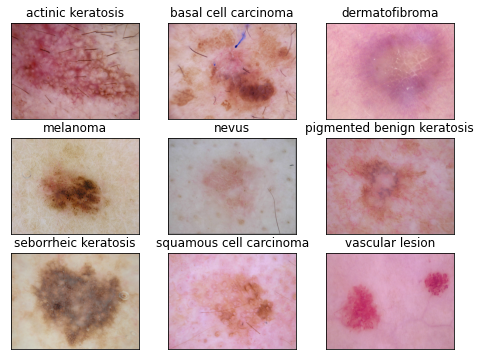

In [14]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
fig = plt.figure(figsize=(8,6))

for i in range(len(class_names)):
    ax = fig.add_subplot(3, 3, 1 + i, xticks=[], yticks=[])
    img = plt.imread(list(data_dir_train.glob("{}/*.jpg".format(class_names[i])))[i]  )
    plt.imshow(img)
    ax.set_title(class_names[i])
plt.show()

In [15]:
# Take one batch of train data and interospect
for image_batch, labels_batch in train_ds.take(1):
    print(labels_batch.shape)
    print(image_batch.shape)
   

(32,)
(32, 180, 180, 3)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [63]:
### Your code goes here
num_classes = 9
model = keras.Sequential(
    [
        layers.Rescaling(scale = 1.0/255, input_shape = (180,180,3) ),        
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu" ,padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu" ,padding='same',),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),  
        layers.Dense(128,activation='relu'),
        layers.Dense(num_classes, activation="softmax")  # 
    ]
)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [64]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              #loss="categorical_crossentropy",
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [65]:
# View the summary of all layers
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 129600)           

### Train the model

In [66]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 34s 595ms/step - loss: 2.4803 - accuracy: 0.2204 - val_loss: 1.7937 - val_accuracy: 0.3445
Epoch 2/20
56/56 [==============================] - 37s 664ms/step - loss: 1.6483 - accuracy: 0.4314 - val_loss: 1.4904 - val_accuracy: 0.4944
Epoch 3/20
56/56 [==============================] - 40s 710ms/step - loss: 1.4408 - accuracy: 0.4983 - val_loss: 1.4338 - val_accuracy: 0.5213
Epoch 4/20
56/56 [==============================] - 40s 716ms/step - loss: 1.3453 - accuracy: 0.5413 - val_loss: 1.4254 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - 40s 721ms/step - loss: 1.1977 - accuracy: 0.5854 - val_loss: 1.7453 - val_accuracy: 0.4832
Epoch 6/20
56/56 [==============================] - 41s 729ms/step - loss: 1.0587 - accuracy: 0.6222 - val_loss: 1.4553 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 41s 737ms/step - loss: 0.9163 - accuracy: 0.6808 - val_loss: 1.5904 - val_accuracy: 0.5526

### Visualizing training results

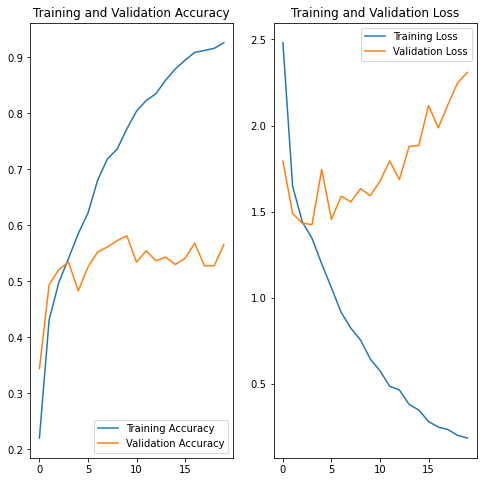

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Result:
after the model fit, we see:
- Training accuracy: 0.92
- Training loss: 0.18 
- validation accuracy: 0.56
- validation loss: 2.30

### Findings:

Clearly by comparing the results we can conclude that the model is definitely overfitting as we have high Train Accuracy and Low Validation Accuracy. <br>
We also see higher Loss value in validation dataset than train dataset.

### Solution:

Need to do some changes in model:
- like doing data augmentation like Flip, Rotate, Zoom on input dataset  
- including dropout in layers


In [69]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape = (img_height, img_width,3)),
     layers.experimental.preprocessing.RandomRotation(0.2),
     layers.experimental.preprocessing.RandomZoom(0.2)
    ]
)



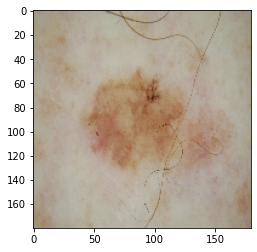

In [77]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_aug1 = ImageDataGenerator(rescale=1./255,
                   horizontal_flip=True,
                   zoom_range=0.2 )

# Let us select one random image from train_ds
image_batch, label_batch = next(iter(train_ds))

temp_img=image_batch[0].numpy()
plt.imshow(temp_img.astype('uint8'))


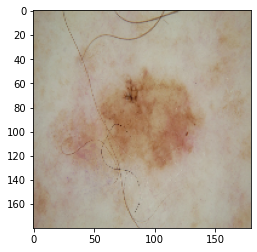

In [78]:
# Let us see the augmented image that is flipped and zoomed
plt.imshow(image_aug1.apply_transform(temp_img, transform_parameters={'flip_horizontal':True}).astype('uint8'))

### Todo:
### Create the model 2 , compile and train


In [81]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

num_classes = 9
model2 = keras.Sequential(
    [   
        data_augmentation,
        layers.Rescaling(scale = 1.0/255, input_shape = (180,180,3) ),        
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu" ,padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu" ,padding='same',),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),
        layers.Flatten(),  
        layers.Dense(128,activation='relu'),       
        layers.Dense(num_classes, activation="softmax")  
    ]
)

### Compiling the model

In [83]:
## Your code goes here
model2.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model2.summary()

### Training the model

In [84]:
## Your code goes here, note: train your model for 20 epochs

epochs=20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 57s 992ms/step - loss: 2.9136 - accuracy: 0.2048 - val_loss: 2.0023 - val_accuracy: 0.2215
Epoch 2/20
56/56 [==============================] - 55s 976ms/step - loss: 1.9436 - accuracy: 0.2500 - val_loss: 1.8625 - val_accuracy: 0.3065
Epoch 3/20
56/56 [==============================] - 55s 986ms/step - loss: 1.7868 - accuracy: 0.3499 - val_loss: 1.6725 - val_accuracy: 0.4430
Epoch 4/20
56/56 [==============================] - 55s 989ms/step - loss: 1.7307 - accuracy: 0.3800 - val_loss: 1.5870 - val_accuracy: 0.4586
Epoch 5/20
56/56 [==============================] - 55s 984ms/step - loss: 1.5077 - accuracy: 0.4715 - val_loss: 1.4848 - val_accuracy: 0.4631
Epoch 6/20
56/56 [==============================] - 54s 973ms/step - loss: 1.4558 - accuracy: 0.4827 - val_loss: 1.3528 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 49s 883ms/step - loss: 1.4614 - accuracy: 0.4933 - val_loss: 1.4618 - val_accuracy: 0.5235

### Visualizing the results

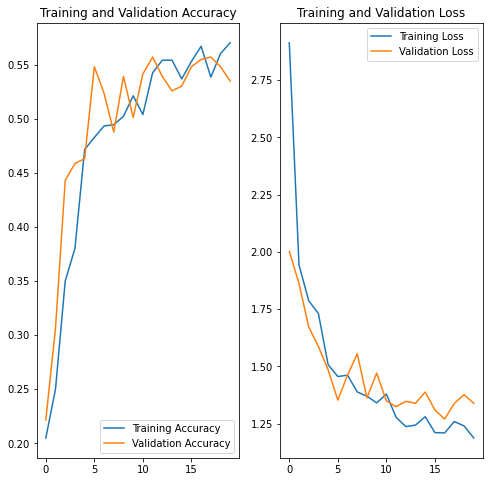

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Result:
after the model fit, we see:
- Training accuracy: 0.57
- validation accuracy: 0.53
- Training loss: 1.18 
- validation loss: 1.33

### Findings:
- Even though test and validation accuracy are not very different, they are quite less ~ 57%
- This shows clear evedence for underfit in the model
- We suspect quite a large class imbalance, within the data for training

#### Let us find the distribution of classes in the training dataset.
####  Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [86]:
## Your code goes here.
test_data_count=[]
for i in class_names:
    num_c = len( list(data_dir_train.glob('{}/*.jpg'.format(i))))
    test_data_count.append(num_c)
    print(i," : ",num_c)

actinic keratosis  :  114
basal cell carcinoma  :  376
dermatofibroma  :  95
melanoma  :  438
nevus  :  357
pigmented benign keratosis  :  462
seborrheic keratosis  :  77
squamous cell carcinoma  :  181
vascular lesion  :  139


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

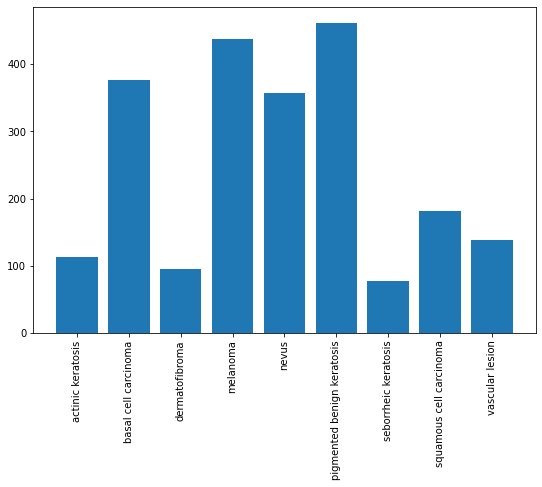

In [90]:
plt.figure(figsize=(9,6))
plt.bar(class_names, test_data_count)
plt.xticks(rotation=90)

#### Findings: We see a large amount of class imbalance between the classes in test data.

####  "seborrheic keratosis" has lowest number of image samples with mear 77

#### While "pigmented benign keratosis" classes dominates the datawith 462 image samples.


#### We shall rectify the class imbalance by using a party python library `Augmentor` by adding more samples across all classes so that none of the classes have very few samples.

In [91]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [94]:
#path_to_training_dataset="To do"
#data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train)  + '/'+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EC1211F430>: 100%|█| 500/500 [00:03<00:00, 152.10 Samples


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1EC11B80970>: 100%|█| 500/500 [00:03<00:


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EC11B806D0>: 100%|█| 500/500 [00:03<00:00, 140.28 Samples


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1EC11B94A00>: 100%|█| 500/500 [00:19<00:00, 25.38 Samples


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x1EC1207D190>: 100%|█| 500/500 [00:20<0


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EC120F08B0>: 100%|█| 500/500 [00:04<00:00, 124.53 Samples


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1EC671F72E0>: 100%|█| 500/500 [00:10<00:00, 45.82 Samples


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1EC1210B040>: 100%|█| 500/500 [00:04<00:


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EC0281E9A0>: 100%|█| 500/500 [00:05<00:00, 88.65 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [95]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [97]:
from glob import glob

In [98]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_123c5d35-45e8-45d4-ba98-e11959c4f558.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_6448da54-a308-4bcc-b9bf-17e487055e5b.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_ab1307ac-e8d4-4f48-be24-1f3b3443a41e.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_c5b74427-75ad-4e0a-8ef1-92228310d485.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_787dbadf-95ce-4a00-b0cd-aacdd27ea848.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration\\Train

In [99]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [101]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [106]:
# checking label
path_list_orig=[]
lesion_list_orig=[]
for i in class_names:
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list_orig.append(str(j))
        lesion_list_orig.append(i)
dataframe_dict_original = dict(zip(path_list_orig, lesion_list_orig))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
print(original_df)

                                                   Path              Label
0     Skin cancer ISIC The International Skin Imagin...  actinic keratosis
1     Skin cancer ISIC The International Skin Imagin...  actinic keratosis
2     Skin cancer ISIC The International Skin Imagin...  actinic keratosis
3     Skin cancer ISIC The International Skin Imagin...  actinic keratosis
4     Skin cancer ISIC The International Skin Imagin...  actinic keratosis
...                                                 ...                ...
2234  Skin cancer ISIC The International Skin Imagin...    vascular lesion
2235  Skin cancer ISIC The International Skin Imagin...    vascular lesion
2236  Skin cancer ISIC The International Skin Imagin...    vascular lesion
2237  Skin cancer ISIC The International Skin Imagin...    vascular lesion
2238  Skin cancer ISIC The International Skin Imagin...    vascular lesion

[2239 rows x 2 columns]


In [107]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [108]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [110]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [113]:
## data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training" ,    
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [114]:
train_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

#### Create a validation dataset

In [115]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create model3

In [116]:
## your code goes here with batchnormalization 

model3 = keras.Sequential()

model3.add(InputLayer((180,180,3)))
model3.add(Rescaling(1.0/255))

model3.add(Conv2D(32, (3, 3), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(64, (3, 3)))
model3.add(BatchNormalization())
model3.add(Activation('relu'))

model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.25))

model3.add(Dense(9, activation='softmax'))


#### Compile  model3 

In [117]:
## Choosing optimizer and loss function appropriately
model3.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


In [120]:
model3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 180, 180, 32)      0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 88, 88, 64)      

#### **Todo:**  Train your model

In [118]:
epochs = 30
## Your code goes here, use 30 epochs.
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 215s 1s/step - loss: 9.9009 - accuracy: 0.2784 - val_loss: 2.2804 - val_accuracy: 0.1433
Epoch 2/30
169/169 [==============================] - 223s 1s/step - loss: 1.6417 - accuracy: 0.3874 - val_loss: 2.1582 - val_accuracy: 0.2405
Epoch 3/30
169/169 [==============================] - 236s 1s/step - loss: 1.4825 - accuracy: 0.4381 - val_loss: 1.5851 - val_accuracy: 0.4001
Epoch 4/30
169/169 [==============================] - 234s 1s/step - loss: 1.3865 - accuracy: 0.4850 - val_loss: 1.5624 - val_accuracy: 0.4677
Epoch 5/30
169/169 [==============================] - 231s 1s/step - loss: 1.3115 - accuracy: 0.5117 - val_loss: 1.9172 - val_accuracy: 0.4120
Epoch 6/30
169/169 [==============================] - 240s 1s/step - loss: 1.2369 - accuracy: 0.5382 - val_loss: 1.4639 - val_accuracy: 0.4595
Epoch 7/30
169/169 [==============================] - 242s 1s/step - loss: 1.0919 - accuracy: 0.5814 - val_loss: 1.0577 - val_accuracy: 0.6132

####  Visualize the model3 results

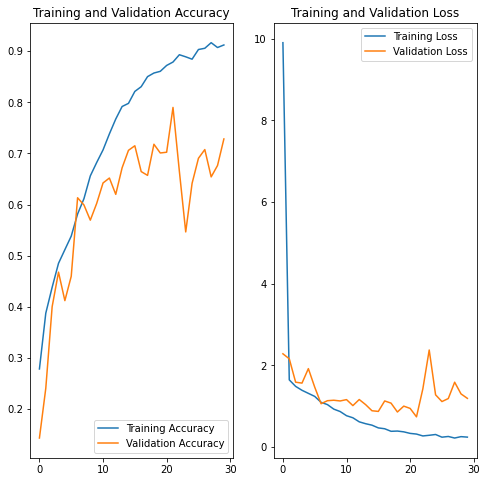

In [119]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Result:

- Train Accuracy - 0.91
- Validation Accuracy - 0.73
- Train Loss - 0.23
- Validation Loss - 1.18

### Findings:

From the above result we come to know this model's validation accuracy is increased when compared to previous models. 
But this model is still overfitting.

Using class re-balancing, droupout, batch normalization helps in acheiving the better results.

The Model can be further improved by the hyperparameter tuning.